In [1]:
import json
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser

In [2]:
with open("../data/emails_extracted.json", 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

In [3]:
df['date']

0             Wed, 24 Apr 2024 20:52:29 +0000
1             Wed, 24 Apr 2024 20:29:00 +0000
2             Wed, 24 Apr 2024 20:23:20 +0000
3             Wed, 24 Apr 2024 20:15:39 +0000
4             Wed, 24 Apr 2024 20:06:38 +0000
                        ...                  
3325    Fri, 26 Jan 2024 10:31:39 -0500 (EST)
3326    Fri, 26 Jan 2024 15:29:22 +0000 (UTC)
3327          Fri, 26 Jan 2024 15:27:32 +0000
3328          Fri, 26 Jan 2024 15:10:36 +0000
3329          Fri, 26 Jan 2024 14:44:17 +0000
Name: date, Length: 3330, dtype: object

In [4]:
df['date'] = df['date'].apply(parser.parse)
df['date'] = pd.to_datetime(df['date'], utc=True)
df['date'] = df['date'].dt.tz_convert('America/Chicago')
df['date'] = df['date'].dt.tz_localize(None)

In [5]:
df['date']

0      2024-04-24 15:52:29
1      2024-04-24 15:29:00
2      2024-04-24 15:23:20
3      2024-04-24 15:15:39
4      2024-04-24 15:06:38
               ...        
3325   2024-01-26 09:31:39
3326   2024-01-26 09:29:22
3327   2024-01-26 09:27:32
3328   2024-01-26 09:10:36
3329   2024-01-26 08:44:17
Name: date, Length: 3330, dtype: datetime64[ns]

In [6]:
df.set_index('date', inplace=True)

In [ ]:
# weekly_emails = df.groupby(['State', 'party', pd.Grouper(freq='W')]).size()
# weekly_emails_df = weekly_emails.reset_index(name='counts')

# pivot_table = weekly_emails_df.pivot_table(index=['State', 'date'], columns='party', values='counts', fill_value=0)

# for state, state_df in pivot_table.groupby(level=0):
#     state_df.droplevel(0).plot(kind='bar', figsize=(12, 6), width=0.8)
#     plt.title(f"Weekly Email Counts by Party in {state}")
#     plt.xlabel("Week")
#     plt.ylabel("Number of Emails")
#     plt.xticks(rotation=45)
#     plt.legend(title='Party')
#     plt.tight_layout()
#     plt.show()

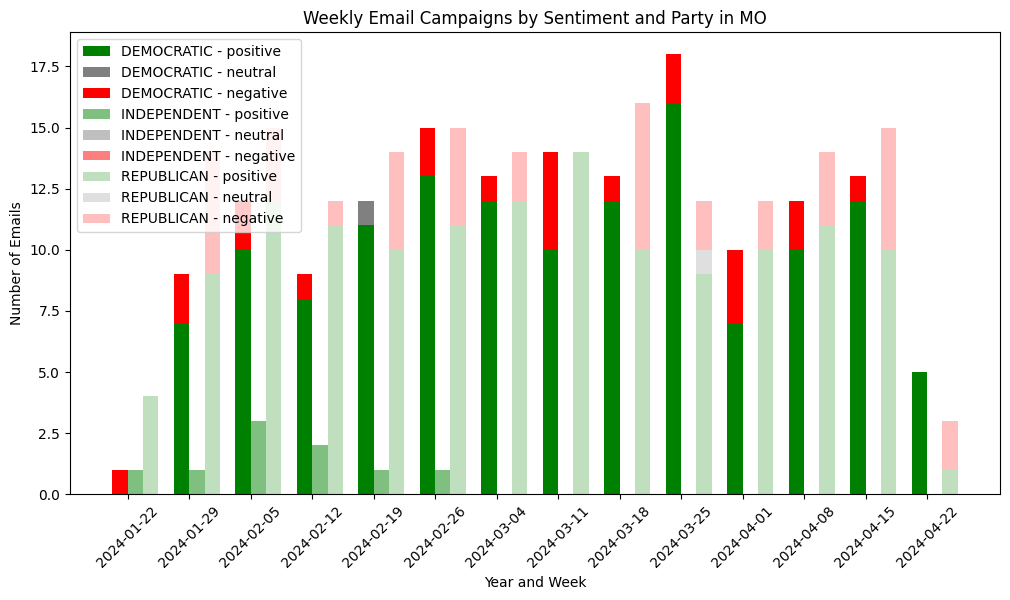

In [7]:
df['year_week'] = df.index.to_period('W')

grouped = df.groupby(['State', 'year_week', 'party', 'content_sentiment']).size()
grouped = grouped.reset_index(name='count')
pivot_table = grouped.pivot_table(index=['State', 'year_week', 'party'], columns='content_sentiment', values='count', fill_value=0)

s = 'MO'
data = pivot_table.xs(s, level='State')

if data.empty:
    print(f"No data available for {s}")
else:
    fig, ax = plt.subplots(figsize=(12, 6)) 
    colors = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}
    alphas = {'DEMOCRATIC': 1.0, 'REPUBLICAN': 0.25, 'INDEPENDENT': 0.5}
    
    # Iterate over each party to plot their data side by side
    width = 0.25 
    parties = data.index.get_level_values('party').unique()
    for i, party in enumerate(parties):
        party_data = data.xs(party, level='party')
        position = np.arange(len(party_data)) - width/2 + i*(width)
        bottom = np.zeros(len(party_data))
        
        # Stack each sentiment
        for sentiment in ['positive', 'neutral', 'negative']:
            ax.bar(position, party_data.get(sentiment, 0), width, label=f'{party} - {sentiment}', bottom=bottom, color=colors[sentiment], alpha=alphas[party])
            bottom += party_data.get(sentiment, 0).fillna(0).values
    
    ax.set_xlabel('Year and Week')
    ax.set_ylabel('Number of Emails')
    ax.set_title(f'Weekly Email Campaigns by Sentiment and Party in {s}')
    ax.set_xticks(np.arange(len(party_data)))
    ax.set_xticklabels(party_data.index.to_timestamp().strftime('%Y-%m-%d'), rotation=45)
    ax.legend()

    plt.show()